In [1]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
print("Download complete.")

!mkdir -p Flickr8k_Dataset
!mkdir -p Flickr8k_Text

!unzip -qq Flickr8k_Dataset.zip -d Flickr8k_Dataset
!unzip -qq Flickr8k_text.zip -d Flickr8k_Text
print("Extraction complete.")

!rm Flickr8k_Dataset.zip Flickr8k_text.zip
print("Zip files removed.")

Download complete.
Extraction complete.
Zip files removed.


In [2]:
import os
import string
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import time
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, Dropout, add ,Concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:
# drive.mount('/content/drive')
# WORKING_DIR = '/content/drive/MyDrive/Flickr8k_GRU/'

BASE_DIR = '/content/'
IMAGE_DIR = os.path.join(BASE_DIR, 'Flickr8k_Dataset/Flicker8k_Dataset')
CAPTION_FILE = os.path.join(BASE_DIR, 'Flickr8k_Text/Flickr8k.token.txt')
WORKING_DIR = '/content/working/'


FEATURES_FILE = os.path.join(WORKING_DIR, 'vgg16_features.pkl')
TOKENIZER_FILE = os.path.join(WORKING_DIR, 'tokenizer.pkl')

In [4]:
EMBEDDING_DIM = 256
GRU_UNITS = 512
VOCAB_FREQ_THRESHOLD = 1
image_shape = (224, 224)

In [5]:
def load_captions(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()

    captions_dict = {}
    for line in text.strip().split('\n'):
        parts = line.split('\t')
        if len(parts) != 2:
            continue
        image_id_raw, caption = parts[0], parts[1]
        image_id = image_id_raw.split('.')[0]

        if image_id not in captions_dict:
            captions_dict[image_id] = []
        captions_dict[image_id].append(caption)

    print(f"Loaded captions for {len(captions_dict)} images.")
    return captions_dict

captions_dict = load_captions(CAPTION_FILE)
# if captions_dict:
#    first_image_id = list(captions_dict.keys())[0]
#    print(f"\nExample Captions for {first_image_id}:")
#    for cap in captions_dict[first_image_id]:
#        print(f"- {cap}")

Loaded captions for 8092 images.


In [6]:
def clean_captions(captions_dict):
    cleaned_captions = {}
    table = str.maketrans('', '', string.punctuation)

    for image_id, caption_list in captions_dict.items():
        cleaned_list = []
        for caption in caption_list:
            caption = caption.lower()
            caption = caption.translate(table)
            caption = ' '.join([word for word in caption.split() if len(word)>1 and word.isalpha()])
            caption = 'startseq ' + caption + ' endseq'
            cleaned_list.append(caption)
        if cleaned_list:
             cleaned_captions[image_id] = cleaned_list
    print(f"Captions cleaned. {len(cleaned_captions)} images remain.")
    return cleaned_captions


cleaned_captions = clean_captions(captions_dict)
image_ids_with_captions = list(cleaned_captions.keys())

Captions cleaned. 8092 images remain.


In [7]:
def build_vocabulary(cleaned_captions, freq_threshold=1):

    all_captions_flat = [caption for sublist in cleaned_captions.values() for caption in sublist]
    if not all_captions_flat:
        print("Error: No captions available to build vocabulary.")
        return None, 0, None, None

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_captions_flat)

    low_freq_words = {word for word, count in tokenizer.word_counts.items() if count <= freq_threshold}
    print(f"Found {len(low_freq_words)} words with frequency <= {freq_threshold}.")

    filtered_texts = []
    for img_id in cleaned_captions:
        for caption in cleaned_captions[img_id]:
            filtered_texts.append(' '.join([word for word in caption.split() if word not in low_freq_words]))

    final_tokenizer = Tokenizer(oov_token='<unk>')
    final_tokenizer.fit_on_texts(filtered_texts)

    vocab_size = len(final_tokenizer.word_index) + 1 # +1 for padding (index 0)
    idx_to_word = {idx: word for word, idx in final_tokenizer.word_index.items()}
    word_to_idx = final_tokenizer.word_index

    print(f"Vocabulary Size (freq >= {freq_threshold}): {vocab_size}")
    return final_tokenizer, vocab_size, idx_to_word, word_to_idx


tokenizer, vocab_size, idx_to_word, word_to_idx = build_vocabulary(cleaned_captions, VOCAB_FREQ_THRESHOLD)

Found 3576 words with frequency <= 1.
Vocabulary Size (freq >= 1): 5191


In [8]:
def get_max_length(cleaned_captions):
    all_captions_flat = [caption for sublist in cleaned_captions.values() for caption in sublist]
    if not all_captions_flat:
        return 0
    return max(len(caption.split()) for caption in all_captions_flat)


max_length = get_max_length(cleaned_captions)
print(f"Maximum caption length: {max_length}")

Maximum caption length: 34


In [9]:
def preprocess_image(image_path, target_size):
    try:
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array.reshape((1, img_array.shape[0], img_array.shape[1], img_array.shape[2]))
        img_array = vgg_preprocess_input(img_array)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None
    return img_array

In [10]:
def extract_features(image_directory, image_ids, cnn_model, shape):
    features = {}
    print(f"Starting feature extraction for {len(image_ids)} images using {cnn_model.name}...")

    for image_id in image_ids:
        image_file = image_id + '.jpg'
        image_path = os.path.join(image_directory, image_file)

        processed_image = preprocess_image(image_path, shape)

        if processed_image is not None:
                feature = cnn_model.predict(processed_image, verbose=0)
                features[image_id] = feature.flatten()


    print(f"\nFinished Extracted features for {len(features)} images.")


    return features

In [11]:
print("Loading VGG16 model...")
base_model = VGG16(weights='imagenet', include_top=True)
cnn_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
print(f"CNN Model loaded for feature extraction.")

Loading VGG16 model...
553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step
CNN Model loaded for feature extraction.


In [12]:
print("Extracting image features...")
image_features = extract_features(IMAGE_DIR, image_ids_with_captions, cnn_model, image_shape)

Extracting image features...
Starting feature extraction for 8092 images using functional...
Error processing image /content/Flickr8k_Dataset/Flicker8k_Dataset/2258277193_586949ec62.jpg: [Errno 2] No such file or directory: '/content/Flickr8k_Dataset/Flicker8k_Dataset/2258277193_586949ec62.jpg'

Finished Extracted features for 8091 images.


In [13]:
final_image_ids = list(image_features.keys())
final_captions_dict = {img_id: cleaned_captions[img_id] for img_id in final_image_ids if img_id in cleaned_captions}
print(f"\nUsing captions and features for {len(final_captions_dict)} images.")

feature_shape = image_features[list(image_features.keys())[0]].shape
print(f"Image feature vector shape: {feature_shape}")


Using captions and features for 8091 images.
Image feature vector shape: (4096,)


In [14]:
class DataGenerator(Sequence):
    def __init__(self, image_ids, captions_dict, features_dict, tokenizer, max_length, vocab_size, batch_size, feature_shape):
        self.image_ids = image_ids
        self.captions_dict = captions_dict
        self.features_dict = features_dict
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.feature_shape = feature_shape

        self.pairs = []
        for img_id in self.image_ids:
             if img_id in self.features_dict and img_id in self.captions_dict:
                 for caption in self.captions_dict[img_id]:
                     self.pairs.append((img_id, caption))

        self.pair_indices = np.arange(len(self.pairs))
        self.on_epoch_end()
        print(f"DataGenerator initialized with {len(self.pairs)} (image, caption) pairs.")

    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.pair_indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_pairs = [self.pairs[k] for k in batch_indices]

        X1_batch_list, X2_batch_list, y_batch_list = [], [], []

        for img_id, caption in batch_pairs:
            if img_id not in self.features_dict:
                continue
            img_feature = self.features_dict[img_id]

            seq = self.tokenizer.texts_to_sequences([caption])[0]

            for i in range(1, len(seq)):
                in_seq, out_word_idx = seq[:i], seq[i]
                in_seq_padded = pad_sequences([in_seq], maxlen=self.max_length, padding='post')[0]
                out_word_one_hot = to_categorical([out_word_idx], num_classes=self.vocab_size)[0]

                X1_batch_list.append(img_feature)
                X2_batch_list.append(in_seq_padded)
                y_batch_list.append(out_word_one_hot)

        X1_batch = np.array(X1_batch_list)
        X2_batch = np.array(X2_batch_list)
        y_batch = np.array(y_batch_list)


        return (X1_batch, X2_batch), y_batch

    def on_epoch_end(self):
        np.random.shuffle(self.pair_indices)
        print("Data shuffled for next epoch.")

In [15]:
all_ids = list(final_captions_dict.keys())
np.random.shuffle(all_ids)
split_ratio = 0.8
split_index = int(len(all_ids) * split_ratio)

train_ids = all_ids[:split_index]
test_ids = all_ids[split_index:]

print(f"Total images: {len(all_ids)}")
print(f"Training images: {len(train_ids)}")
print(f"Testing images: {len(test_ids)}")


BATCH_SIZE = 64

train_generator = DataGenerator(train_ids, final_captions_dict, image_features, tokenizer, max_length, vocab_size, BATCH_SIZE, feature_shape)
test_generator = DataGenerator(test_ids, final_captions_dict, image_features, tokenizer, max_length, vocab_size, BATCH_SIZE, feature_shape)


Total images: 8091
Training images: 6472
Testing images: 1619
Data shuffled for next epoch.
DataGenerator initialized with 32360 (image, caption) pairs.
Data shuffled for next epoch.
DataGenerator initialized with 8095 (image, caption) pairs.


In [16]:
def define_captioning_model(vocab_size, max_length, embedding_dim, feature_shape, rnn_units):


    inputs1 = Input(shape=feature_shape, name="image_features_input")
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(rnn_units, activation='relu', name="image_feature_dense")(fe1)

    inputs2 = Input(shape=(max_length,), name="sequence_input")
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True, name="embedding")(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = GRU(rnn_units, name="gru_layer")(se2)
    decoder1 = add([fe2, se3], name="add_features")
    decoder2 = Dense(rnn_units, activation='relu', name="decoder_dense")(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name="output_softmax")(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs, name="image_captioning_GRU_model")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    return model

model = define_captioning_model(vocab_size, max_length, EMBEDDING_DIM, feature_shape, GRU_UNITS)

Model: "image_captioning_GRU_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_features_inp… │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  1,328,896 │ sequence_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ image_features_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ sequence_input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_feature_dense │ (None, 512)       │  2,097,664 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_layer (GRU)     │ (None, 512)       │  1,182,720 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_features (Add)  │ (None, 512)       │          0 │ image_feature_de… │
│                     │                   │            │ gru_layer[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 512)       │    262,656 │ add_features[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_softmax      │ (None, 5191)      │  2,662,983 │ decoder_dense[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,534,919 (28.74 MB)

 Trainable params: 7,534,919 (28.74 MB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
EPOCHS = 10

print(f"Starting training for {EPOCHS} epochs...")
start_train_time = time.time()

model_checkpoint_path = os.path.join(WORKING_DIR, 'best_model_gru.keras')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

Starting training for 10 epochs...


In [18]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator),
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=1
)


#print(f"Loading best model from {model_checkpoint_path}...")
# model = tf.keras.models.load_model(model_checkpoint_path) # Use this if you stopped and restarted

Data shuffled for next epoch.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1788 - loss: 4.9980Data shuffled for next epoch.
Data shuffled for next epoch.
Data shuffled for next epoch.

Epoch 1: val_loss improved from inf to 3.74186, saving model to /content/working/best_model_gru.keras
506/506 ━━━━━━━━━━━━━━━━━━━━ 54s 94ms/step - accuracy: 0.1790 - loss: 4.9966 - val_accuracy: 0.2876 - val_loss: 3.7419
Epoch 2/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3121 - loss: 3.3752Data shuffled for next epoch.
Data shuffled for next epoch.
Data shuffled for next epoch.

Epoch 2: val_loss improved from 3.74186 to 3.58009, saving model to /content/working/best_model_gru.keras
506/506 ━━━━━━━━━━━━━━━━━━━━ 78s 92ms/step - accuracy: 0.3121 - loss: 3.3751 - val_accuracy: 0.3103 - val_loss: 3.5801
Epoch 3/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3491 - loss: 2.9663Data shuffled for next epoch.
Data shuffled for next epoch.
Data shuffled for next epoch.

Epoch 3: val_loss improved from 3.

In [19]:
print("Evaluating model on the test set...")
evaluation_results = model.evaluate(test_generator, steps=len(test_generator), verbose=1)

print("\nTest Set Evaluation:")
print(f"Loss: {evaluation_results[0]:.4f}")
print(f"Accuracy: {evaluation_results[1]:.4f}")

# Add BLEU score calculation here if desired
# This requires generating captions for the test set and comparing to ground truth

Evaluating model on the test set...
Data shuffled for next epoch.
126/127 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3196 - loss: 3.5600Data shuffled for next epoch.
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.3196 - loss: 3.5602

Test Set Evaluation:
Loss: 3.5766
Accuracy: 0.3169


In [20]:
def generate_caption(model, tokenizer, image_features, max_length, idx_to_word):
    if image_features.ndim == 1:
         image_features = np.expand_dims(image_features, axis=0)

    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence_padded = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([image_features, np.array(sequence_padded)], verbose=0)
        yhat_idx = np.argmax(yhat)
        word = idx_to_word.get(yhat_idx, None)

        if word is None or word == 'endseq':
            break

        in_text += ' ' + word

    final_caption = in_text.replace('startseq ', '').replace(' endseq', '').strip()
    return final_caption


Testing inference on image ID: 2698487246_e827404cac
Generated Caption: two men playing basketball
Generated Caption: two men playing basketball
Generated Caption: two men playing basketball
Generated Caption: two men playing basketball
Generated Caption: two men playing basketball


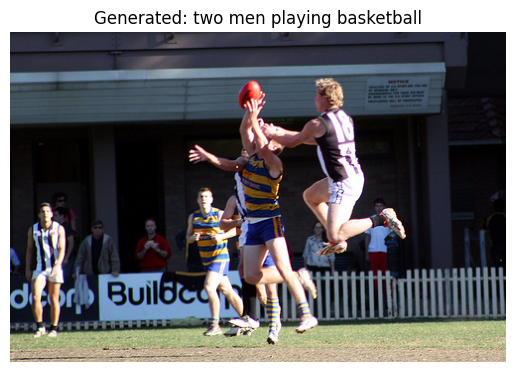

Original Captions:
- man in black and white jersey is leaping to get ball from player in blue and yellow jersey
- people playing sport with referee looking on
- the men are jumping in the air
- three rugby players trying to catch the ball
- two men are jumping into the air to catch the football


In [21]:

if test_ids:
    random_test_id = np.random.choice(test_ids)
    print(f"\nTesting inference on image ID: {random_test_id}")

    if random_test_id in image_features:
        test_feature = image_features[random_test_id]
        for _ in range(5):
          generated_caption = generate_caption(model, tokenizer, test_feature, max_length, idx_to_word)
          print(f"Generated Caption: {generated_caption}")

        image_file = random_test_id + '.jpg'
        image_path = os.path.join(IMAGE_DIR, image_file)
        if os.path.exists(image_path):
            img = Image.open(image_path)
            plt.imshow(img)
            plt.title(f"Generated: {generated_caption}")
            plt.axis('off')
            plt.show()
        else:
            print(f"Image file not found: {image_path}")

        print("Original Captions:")
        if random_test_id in final_captions_dict:
             original_caps = [cap.replace('startseq ','').replace(' endseq','') for cap in final_captions_dict[random_test_id]]
             for orig_cap in original_caps:
                 print(f"- {orig_cap.strip()}")
        else:
            print("Original captions not found in final_captions_dict.")

    else:
        print(f"Features not found for image ID: {random_test_id}")
else:
    print("Test set is empty, cannot run inference test.")

In [22]:
def generate_caption_with_sampling(model, tokenizer, image_features, max_length, idx_to_word, temperature=1.0):

    if image_features.ndim == 1:
         image_features = np.expand_dims(image_features, axis=0)

    in_text = 'startseq'
    generated_sequence = ['startseq']

    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence_padded = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([image_features, np.array(sequence_padded)], verbose=0)[0]
        yhat = np.asarray(yhat).astype('float64') + 1e-10
        scaled_logits = np.log(yhat) / temperature
        scaled_logits = scaled_logits - np.max(scaled_logits)
        exp_preds = np.exp(scaled_logits)
        probabilities = exp_preds / np.sum(exp_preds)


        probabilities = probabilities / np.sum(probabilities)
        next_word_idx = np.random.choice(len(probabilities), p=probabilities)

        word = idx_to_word.get(next_word_idx, None)

        if word is None or word == 'endseq':
            break

        in_text += ' ' + word
        generated_sequence.append(word)

    if generated_sequence[0] == 'startseq':
        generated_sequence = generated_sequence[1:]
    if generated_sequence and generated_sequence[-1] == 'endseq':
         generated_sequence = generated_sequence[:-1]

    final_caption = ' '.join(generated_sequence).strip()
    return final_caption


Testing sampling inference on image ID: 2630507245_bea4804288
Temp=0.5: dog with number and number is running
Temp=0.8: dog is wearing green shirt wearing number strip
Temp=1.0: dogs racing in race
Temp=1.2: greyhound greyhound muzzled dogs race in midair position


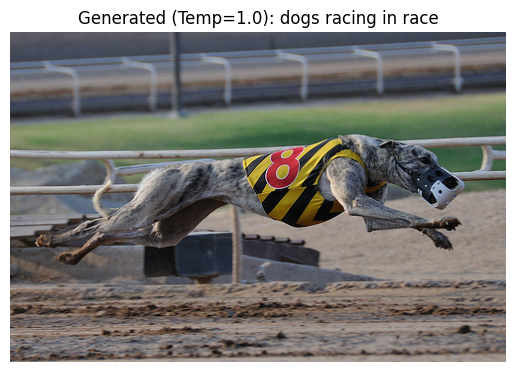

Original Captions:
- fast running greyhound during race
- greyhound dog is running through turn on muddy track
- racing greyhound dog wearing number
- the dog with the racing number is in midjump
- the racing greyhound is running on the racetrack


In [23]:
if test_ids:
    random_test_id = np.random.choice(test_ids)
    print(f"\nTesting sampling inference on image ID: {random_test_id}")

    if random_test_id in image_features:
        test_feature = image_features[random_test_id]

        temperatures_to_try = [0.5, 0.8, 1.0, 1.2]
        generated_captions = {}
        for temp in temperatures_to_try:
            caption = generate_caption_with_sampling(model, tokenizer, test_feature, max_length, idx_to_word, temperature=temp)
            generated_captions[temp] = caption
            print(f"Temp={temp:.1f}: {caption}")


        image_file = random_test_id + '.jpg'
        image_path = os.path.join(IMAGE_DIR, image_file)
        if os.path.exists(image_path):
            img = Image.open(image_path)
            plt.imshow(img)
            plt.title(f"Generated (Temp=1.0): {generated_captions.get(1.0, 'N/A')}")
            plt.axis('off')
            plt.show()
        else:
            print(f"Image file not found: {image_path}")

        print("Original Captions:")
        if random_test_id in final_captions_dict:
             original_caps = [cap.replace('startseq ','').replace(' endseq','') for cap in final_captions_dict[random_test_id]]
             for orig_cap in original_caps:
                 print(f"- {orig_cap.strip()}")
        else:
            print("Original captions not found in final_captions_dict.")

    else:
        print(f"Features not found for image ID: {random_test_id}")
else:
    print("Test set is empty, cannot run inference test.")


--- Generating Captions for Custom Images ---

Processing: /content/1.jpg


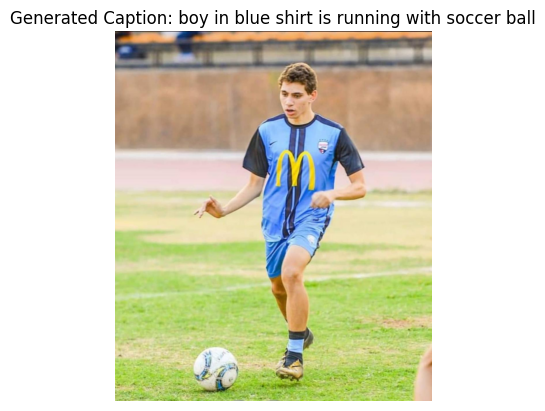

Generated Caption: boy in blue shirt is running with soccer ball

Processing: /content/2.jpg


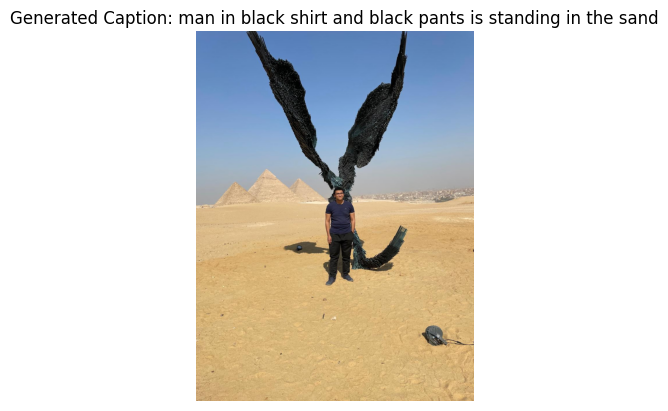

Generated Caption: man in black shirt and black pants is standing in the sand

Processing: /content/3.jpg


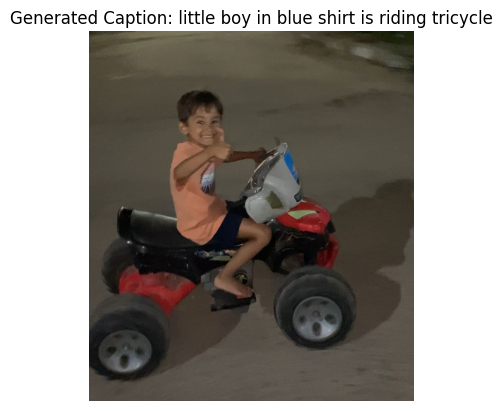

Generated Caption: little boy in blue shirt is riding tricycle

Processing: /content/4.jpg


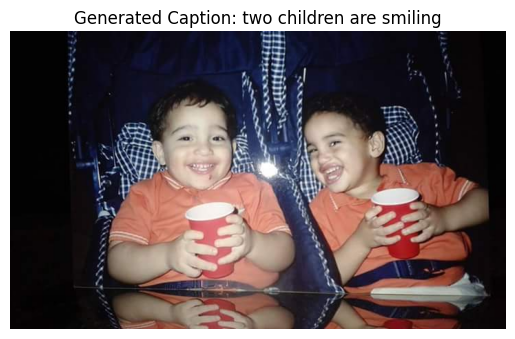

Generated Caption: two children are smiling

Processing: /content/5.jpg


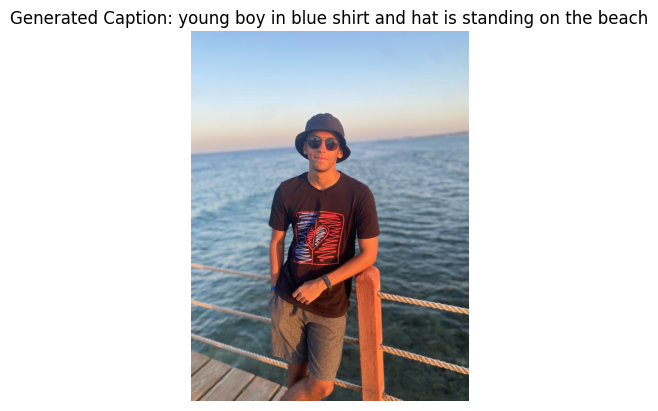

Generated Caption: young boy in blue shirt and hat is standing on the beach

--- Custom Image Captioning Complete ---


In [39]:
print("\n--- Generating Captions for Custom Images ---")

new_image_paths = [
    '/content/1.jpg',
    '/content/2.jpg',
    '/content/3.jpg',
    '/content/4.jpg',
    '/content/5.jpg'
]

for img_path in new_image_paths:
    if not os.path.exists(img_path):
        print(f"Error: Custom image not found at {img_path}. Skipping.")
        continue

    print(f"\nProcessing: {img_path}")

    preprocessed_img = preprocess_image(img_path, image_shape)
    if preprocessed_img is None:
         print(f"Skipping {img_path} due to preprocessing issue.")
         continue

    features = cnn_model.predict(preprocessed_img, verbose=0)
    features = features.flatten()

    caption = generate_caption(model, tokenizer, features, max_length, idx_to_word)

    image = Image.open(img_path)
    plt.imshow(image)
    plt.title(f"Generated Caption: {caption}")
    plt.axis('off')
    plt.show()
    print(f"Generated Caption: {caption}")

print("\n--- Custom Image Captioning Complete ---")